# Effect of Standardization, Batch Normalization

---

# Python & Jupyter setups

In [1]:
from typing import (
    Optional,
    Union,
    List,
    Dict,
    Tuple,
    Callable
)

### Python path
Python path setup to avoid the relative imports.

In [2]:
import sys
import os 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Package dependencies

In [3]:
import inspect
from functools import partial
import copy
import logging
import numpy as np
import matplotlib.pyplot as plt

### Jupyter notebook

In [4]:
#!conda install line_profile memory_profiler
%load_ext memory_profiler
%load_ext line_profiler

# Logging is enabled by calling logging.basicConfig
# logging.basicConfig(stream=sys.stdout, level=logging.ERROR)
# Logger = logging.getLogger("neural_network")

%load_ext autoreload
%autoreload 2

### Matplotlib

In [5]:
import matplotlib.style as mplstyle
mplstyle.use('fast')
plt.ion()

# Note: with notebook backend from the top, updating the plot line does not work...
%matplotlib notebook
# %matplotlib inline

### numpy

In [6]:
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=80) 

## Weight

Weight initialization depends on the activation functions although the Batch Normalization may make it less significant.

* [Xavier](http://proceedings.mlr.press/v9/glorot10a) for a symmetric activation e.g. sigmod
* [He](https://arxiv.org/abs/1502.01852) for ReLu

In [7]:
from common.weights import (
    xavier,
    he,
    uniform
)

In [24]:
%reload_ext autoreload
%autoreload 2
from layer import (
    Matmul,
    ReLU,
    Sigmoid,
    BatchNormalization,
    Standardization,
    FeatureScaleShift,
    CrossEntropyLogLoss
)

---

# Classification

In [9]:
%reload_ext autoreload
%autoreload 2
from data import (
    linear_separable,
    linear_separable_sectors,
)
from drawing import (
    COLOR_LABELS,   # labels to classify outside/0/red or inside/1/green.
    plot,
    plot_on_ax,
    scatter,
    plot_categorical_predictions
)

from common.function import (
    transform_X_T,
    prediction_grid_2d
)
from layer.constants import (
    _WEIGHTS,
    _NAME,
    _SCHEME,
    _OPTIMIZER,
    _NUM_NODES,
    _NUM_FEATURES,
    _PARAMETERS,
    _LOSS_FUNCTION,
    _COMPOSITE_LAYER_SPEC,
    _LOG_LEVEL
)
from optimizer import (
    SGD
)
from network.sequential import (
    SequentialNetwork
)

In [10]:
%matplotlib notebook

def draw_training(X, W, _ax=None, _fig=None, colors=['b']):
    w0 = W[0]
    w1 = W[1]
    w2 = W[2]
    
    x = np.linspace(-3,3,100)
    if _ax.lines:
        for line in _ax.lines:
            line.set_xdata(x)
            y = -w1/w2 * x - w0 / w2
            line.set_ydata(y)
    else:
        for color in colors:
            y = -w1/w2 * x - w0 / w2
            _ax.plot(x, y, color)

    fig.canvas.draw()

    _x = np.linspace(-3,3,100)
    _y = -w1/w2 * x - w0 / w2
    _ax.plot(_x, _y, label='linear')  # Plot some data on the _axes.
    
    
def run_training(network, epoch: int, x, t, c):
    # Train
    for i in range(epoch):
        network.train(X=x, T=t)
        if not (i % 1000): 
            print(f"iteration {i} Loss {network.L}")

    fig, ax = plt.subplots(1, 2, figsize=(9,4)) 
    x_min, x_max = x[:, 0].min(), x[:, 0].max()
    y_min, y_max = x[:, 1].min(), x[:, 1].max()

    # Plot errors
    _x = range(len(network.history))
    _y = network.history
    xlabel = 'iterations (log scale)'
    ylabel = 'loss'
    title = "training error"
    plot_on_ax(ax[0], _x, _y, title=title, xlabel=xlabel, ylabel=ylabel)
    #ax.set_ylim(0.0, 1.5)
    ax[0].set_xscale('log')

    # Plot predictions
    x_grid, y_grid, predictions = prediction_grid_2d(x_min, x_max, y_min, y_max, network.predict)
    plot_categorical_predictions(ax[1], [x_grid, y_grid], x, c, predictions)
    ax[1].axis('equal')
    ax[1].set_xlim(-3, 3)
    ax[1].set_ylim(-3, 3)
    ax[1].grid()
    ax[1].set_title("Predictions")

---

# Categorical Classification Non-Linearly separable data

In [11]:
%reload_ext autoreload
%autoreload 2

from data import (
    set_in_a_radius,
    sets_of_circle_A_not_B
)

## Data X and Label T
Training data set that cannot be linearly classified. ```X = ((A not B), (B not C), (C not A), (A and B and C and D))``` for circles A, B, C.

<IPython.core.display.Javascript object>


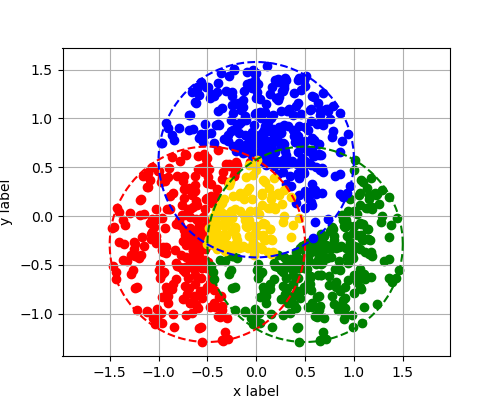

In [12]:
__M = 3        # Number of circles
__N = 500
radius = 1
circles, centres, intersection = sets_of_circle_A_not_B(radius=radius, ratio=1.0, m=__M, n=__N)

fig, ax = plt.subplots(figsize=(5,4)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
r = np.linspace(0, 2*np.pi, 100)

# (A not B), (B not C), (C not A)
for i in range(__M):
    circle = circles[i]
    if circle.size > 0:
        x = centres[i][0]
        y = centres[i][1]
        ax.scatter(circle[::, 0], circle[::, 1], color=COLOR_LABELS[i])
        ax.plot(
            x + radius * np.cos(r), 
            y + radius * np.sin(r), 
            linestyle='dashed', 
            color=COLOR_LABELS[i]
        )

# (A and B and C and D)
M = __M + 1
ax.scatter(intersection[::, 0], intersection[::, 1], color='gold')

In [13]:
# Stack all circles and intersect
X_cat_nl = np.vstack(
    [circles[i] for i in range(M-1)] + 
    [intersection]
)

T_cat_nl = np.hstack(
    [np.full(circles[i].shape[0], i) for i in range(M-1)] + 
    [np.full(intersection.shape[0], M-1)]
)
N_cat_nl = T_cat_nl.shape[0]
assert T_cat_nl.shape[0] == X_cat_nl.shape[0]

# Shuffle the data
indices = np.random.permutation(range(T_cat_nl.shape[0]))
X_cat_nl = X_cat_nl[indices]
T_cat_nl = T_cat_nl[indices]
Y_cat_nl = COLOR_LABELS[T_cat_nl]
X_cat_nl, T_cat_nl = transform_X_T(X_cat_nl, T_cat_nl)

print(f"X:{X_cat_nl.shape} T:{T_cat_nl.shape} ")

X:(1012, 2) T:(1012,) 


## Construct a neural network

In [14]:
MAX_TEST_TIMES = 50000
D = 2
M01 = 8
M02: int = M  # Number of categories to classify
    
W01 = he(M01, D+1)
W02 = he(M02, M01+1)

### Compose a neural network specification

In [15]:
LAYER_INDEX_MATMUL01 = 1
LAYER_INDEX_MATMUL02 = 3

sequential_layer_specification = {
    "std01": Standardization.specification(
        name="std01",
        num_nodes=D,
        momentum=0.9
    ),
    "matmul01": Matmul.specification(
        name="matmul01", 
        num_nodes=M01, 
        num_features=D, 
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05, 
            l2=1e-3
        )
    ), 
    "relu01": ReLU.specification(
        name="relu01", 
        num_nodes=M01,     
    ),
#    "sigmoid01": Sigmoid.specification(
#        name="sigmoid01", 
#        num_nodes=M01,     
#    ),
    "matmul02": Matmul.specification(
        name="matmul02", 
        num_nodes=M02, 
        num_features=M01, 
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05, 
            l2=1e-3
        )
    ), 
    "loss": CrossEntropyLogLoss.specification(
        name="loss001", num_nodes=M
    )
}

network_specification = {
    _NAME: "two_layer_classifier",
    _NUM_NODES: M,
    _LOG_LEVEL: logging.ERROR,
    _COMPOSITE_LAYER_SPEC: sequential_layer_specification
}
#import json
#print(json.dumps(network_specification, indent=4))

### Instantiate the network

In [16]:
network = SequentialNetwork.build(
    specification=network_specification,
)

# Reset the weights to use the same later in the batch normazliation version
network.layer_inference.layers[LAYER_INDEX_MATMUL01]._W = copy.deepcopy(W01) 
network.layer_inference.layers[LAYER_INDEX_MATMUL02]._W = copy.deepcopy(W02) 

np.array_equal(W01, network.layer_inference.layers[LAYER_INDEX_MATMUL01].W) and \
np.array_equal(W02, network.layer_inference.layers[LAYER_INDEX_MATMUL02].W)

True

## Run training

iteration 0 Loss 1.4389676561715847
iteration 1000 Loss 0.2821841931462269
iteration 2000 Loss 0.24428147641410944
iteration 3000 Loss 0.22764481552927576
iteration 4000 Loss 0.2145393826970425
iteration 5000 Loss 0.19375976549244964
iteration 6000 Loss 0.17556992126627172
iteration 7000 Loss 0.16051936673075964
iteration 8000 Loss 0.14770615979531881
iteration 9000 Loss 0.13620237602233723
iteration 10000 Loss 0.12603767056619333
iteration 11000 Loss 0.1175067840617271
iteration 12000 Loss 0.11016154900933006
iteration 13000 Loss 0.10273000590016093
iteration 14000 Loss 0.09675604356819723
iteration 15000 Loss 0.0921492106502185
iteration 16000 Loss 0.08839196757516705
iteration 17000 Loss 0.08522135686429384
iteration 18000 Loss 0.0824824726212993
iteration 19000 Loss 0.08007765954165173
iteration 20000 Loss 0.077825534646094
iteration 21000 Loss 0.07574020891223554
iteration 22000 Loss 0.07378533809671173
iteration 23000 Loss 0.07202058735226786
iteration 24000 Loss 0.07043450050714

<IPython.core.display.Javascript object>


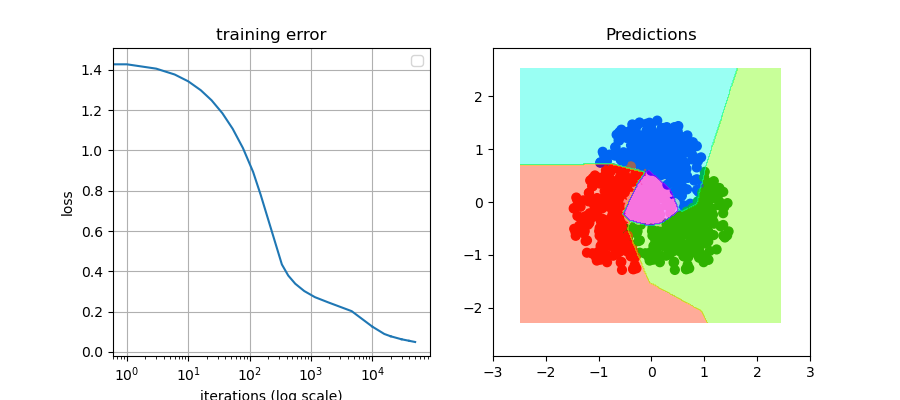

No handles with labels found to put in legend.
/home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/drawing/function.py:79: UserWarning: linewidths is ignored by contourf
  axes.contourf(grid[0], grid[1], predictions, cmap=plt.cm.gist_rainbow, alpha=0.4, linewidths=3.0)


In [17]:
run_training(network=network, epoch=MAX_TEST_TIMES, x=X_cat_nl, t=T_cat_nl, c=Y_cat_nl)

# Batch normalization
Observe the effect of the batch normalization by inserting the layer in-between activation and matmul layers.

### Compose the neural network specification

In [18]:
NET_BN_LAYER_INDEX_MATMUL01 = 1
NET_BN_LAYER_INDEX_MATMUL02 = 4

sequential_layer_specification_bn = {
    "std01": Standardization.specification(
        name="std01",
        num_nodes=D,
        momentum=0.9
    ),
    "matmul01": Matmul.specification(
        name="matmul01",
        num_nodes=M01,
        num_features=D,
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3
        )
    ),
    "bn01": BatchNormalization.specification(
        name="bn01",
        num_nodes=M01,
        gamma_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3
        ),
        beta_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3,
        ),
        momentum=0.9
    ),
    "relu01": ReLU.specification(
        name="relu01",
        num_nodes=M01,
    ),
#    "sigmoid01": Sigmoid.specification(
#        name="sigmoid01", 
#        num_nodes=M01,     
#    ),
    "matmul02": Matmul.specification(
        name="matmul02",
        num_nodes=M02,
        num_features=M01,
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3
        )
    ),
    "loss": CrossEntropyLogLoss.specification(
        name="loss001", num_nodes=M
    )
}


network_specification_bn = {
    _NAME: "two_layer_classifier_with_batch_normalization",
    _NUM_NODES: M,
    _LOG_LEVEL: logging.ERROR,
    _COMPOSITE_LAYER_SPEC: sequential_layer_specification_bn
}

#import json
#print(json.dumps(network_specification_bn, indent=4))

### Instantiate the network

In [19]:
network_bn = SequentialNetwork.build(
    specification=network_specification_bn,
)

# Use the same weights used in non-batch-normalization network
network_bn.layer_inference.layers[NET_BN_LAYER_INDEX_MATMUL01]._W = copy.deepcopy(W01)
network_bn.layer_inference.layers[NET_BN_LAYER_INDEX_MATMUL02]._W = copy.deepcopy(W02)

np.array_equal(W01, network_bn.layer_inference.layers[NET_BN_LAYER_INDEX_MATMUL01].W) and\
np.array_equal(W02, network_bn.layer_inference.layers[NET_BN_LAYER_INDEX_MATMUL02].W)

True

## Run training

iteration 0 Loss 1.3513795252528378
iteration 1000 Loss 0.28705106003764597
iteration 2000 Loss 0.230873118432517
iteration 3000 Loss 0.1953395445554116
iteration 4000 Loss 0.16760446036463703
iteration 5000 Loss 0.1466701587429005
iteration 6000 Loss 0.13071336976634962
iteration 7000 Loss 0.11796898804470132
iteration 8000 Loss 0.10690087000721082
iteration 9000 Loss 0.09780177711723441
iteration 10000 Loss 0.0904694271335065
iteration 11000 Loss 0.08431177965979438
iteration 12000 Loss 0.0793183759077469
iteration 13000 Loss 0.07514908484406338
iteration 14000 Loss 0.07166891798935407
iteration 15000 Loss 0.06865429472477703
iteration 16000 Loss 0.06603091351044194
iteration 17000 Loss 0.0637502876194522
iteration 18000 Loss 0.061598752780275864
iteration 19000 Loss 0.05971760956271445
iteration 20000 Loss 0.057975571948697895
iteration 21000 Loss 0.05634894820478627
iteration 22000 Loss 0.05490853271249564
iteration 23000 Loss 0.05358519899658559
iteration 24000 Loss 0.052287186905

<IPython.core.display.Javascript object>


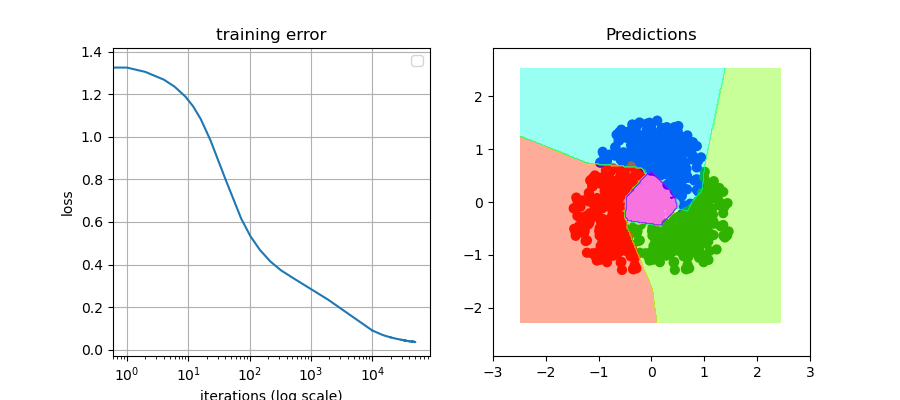

No handles with labels found to put in legend.


In [20]:
run_training(network=network_bn, epoch=MAX_TEST_TIMES, x=X_cat_nl, t=T_cat_nl, c=Y_cat_nl)

# Standardization

Instead of Batch Normailzation, place Standardization (without gamma * X + beta scaling).

In [21]:
NET_STD_LAYER_INDEX_MATMUL01 = 1
NET_STD_LAYER_INDEX_MATMUL02 = 4

sequential_layer_specification_std = {
    "std01": Standardization.specification(
        name="std01",
        num_nodes=D,
        momentum=0.9
    ),
    "matmul01": Matmul.specification(
        name="matmul01",
        num_nodes=M01,
        num_features=D,
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3
        )
    ),
    "std02": Standardization.specification(
        name="std02",
        num_nodes=M01,
        momentum=0.9
    ),
    "relu01": ReLU.specification(
        name="relu01",
        num_nodes=M01,
    ),
    "matmul02": Matmul.specification(
        name="matmul02",
        num_nodes=M02,
        num_features=M01,
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3
        )
    ),
    "loss": CrossEntropyLogLoss.specification(
        name="loss001", num_nodes=M
    )
}


network_specification_std = {
    _NAME: "two_layer_classifier_with_batch_normalization",
    _NUM_NODES: M,
    _LOG_LEVEL: logging.ERROR,
    _COMPOSITE_LAYER_SPEC: sequential_layer_specification_std
}

#import json
#print(json.dumps(network_specification_bn, indent=4))

In [22]:
network_std = SequentialNetwork.build(
    specification=network_specification_std,
)

# Use the same weights used in non-batch-normalization network
network_std.layer_inference.layers[NET_STD_LAYER_INDEX_MATMUL01]._W = copy.deepcopy(W01)
network_std.layer_inference.layers[NET_STD_LAYER_INDEX_MATMUL02]._W = copy.deepcopy(W02)

np.array_equal(W01, network_std.layer_inference.layers[NET_STD_LAYER_INDEX_MATMUL01].W) and\
np.array_equal(W02, network_std.layer_inference.layers[NET_STD_LAYER_INDEX_MATMUL02].W)

True

iteration 0 Loss 1.3513795252528378
iteration 1000 Loss 0.3246674528009957
iteration 2000 Loss 0.28089883650348757
iteration 3000 Loss 0.259907493410598
iteration 4000 Loss 0.2462298458744713
iteration 5000 Loss 0.23654339712359185
iteration 6000 Loss 0.22925470033713582
iteration 7000 Loss 0.22349005251321555
iteration 8000 Loss 0.21874825831663225
iteration 9000 Loss 0.21475901837704986
iteration 10000 Loss 0.21131898872364
iteration 11000 Loss 0.20831887603266608
iteration 12000 Loss 0.20566854702217693
iteration 13000 Loss 0.20329247378354814
iteration 14000 Loss 0.2011603020808574
iteration 15000 Loss 0.1992773375228934
iteration 16000 Loss 0.1974751466983801
iteration 17000 Loss 0.19586478787939143
iteration 18000 Loss 0.19438672769977042
iteration 19000 Loss 0.19301920545563453
iteration 20000 Loss 0.19175749783202542
iteration 21000 Loss 0.1905838407278448
iteration 22000 Loss 0.18948866608089476
iteration 23000 Loss 0.18846399767728006
iteration 24000 Loss 0.18750272993683856


<IPython.core.display.Javascript object>


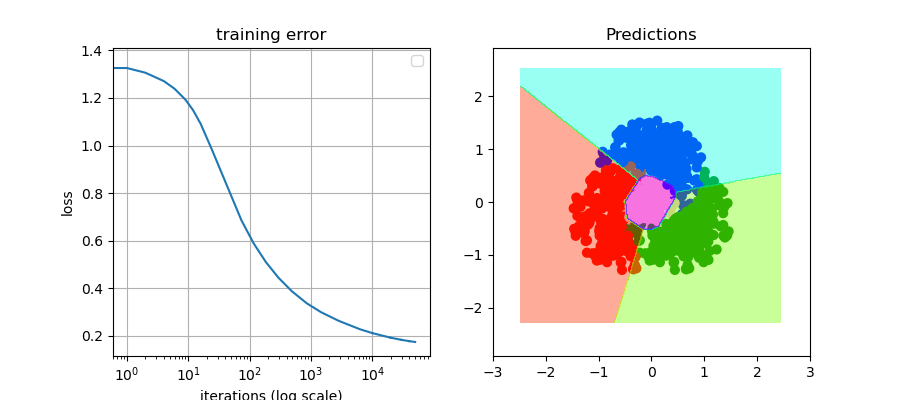

No handles with labels found to put in legend.


In [23]:
run_training(network=network_std, epoch=MAX_TEST_TIMES, x=X_cat_nl, t=T_cat_nl, c=Y_cat_nl)

## Add FeatureScaleShift layer after std02

In [26]:
NET_STD_FSS_LAYER_INDEX_MATMUL01 = 1
NET_STD_FSS_LAYER_INDEX_MATMUL02 = 5

sequential_layer_specification_std_fss = {
    "std01": Standardization.specification(
        name="std01",
        num_nodes=D,
        momentum=0.9
    ),
    "matmul01": Matmul.specification(
        name="matmul01",
        num_nodes=M01,
        num_features=D,
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3
        )
    ),
    "std02": Standardization.specification(
        name="std02",
        num_nodes=M01,
        momentum=0.9
    ),
    "fss02": FeatureScaleShift.specification(
        name="fss02",
        num_nodes=M01,
        gamma_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3
        )
    ),
    "relu01": ReLU.specification(
        name="relu01",
        num_nodes=M01,
    ),
    "matmul02": Matmul.specification(
        name="matmul02",
        num_nodes=M02,
        num_features=M01,
        weights_initialization_scheme="he",
        weights_optimizer_specification=SGD.specification(
            lr=0.05,
            l2=1e-3
        )
    ),
    "loss": CrossEntropyLogLoss.specification(
        name="loss001", num_nodes=M
    )
}


network_specification_std_fss = {
    _NAME: "two_layer_classifier_with_std_fss",
    _NUM_NODES: M,
    _LOG_LEVEL: logging.ERROR,
    _COMPOSITE_LAYER_SPEC: sequential_layer_specification_std_fss
}

#import json
#print(json.dumps(network_specification_bn, indent=4))

In [28]:
network_std_fss = SequentialNetwork.build(
    specification=network_specification_std_fss,
)

# Use the same weights used in non-batch-normalization network
network_std_fss.layer_inference.layers[NET_STD_FSS_LAYER_INDEX_MATMUL01]._W = copy.deepcopy(W01)
network_std_fss.layer_inference.layers[NET_STD_FSS_LAYER_INDEX_MATMUL02]._W = copy.deepcopy(W02)

np.array_equal(W01, network_std_fss.layer_inference.layers[NET_STD_FSS_LAYER_INDEX_MATMUL01].W) and\
np.array_equal(W02, network_std_fss.layer_inference.layers[NET_STD_FSS_LAYER_INDEX_MATMUL02].W)

True

iteration 0 Loss 1.3513795252528378
iteration 1000 Loss 0.28705106003764597
iteration 2000 Loss 0.230873118432517
iteration 3000 Loss 0.1953395445554116
iteration 4000 Loss 0.16760446036463703
iteration 5000 Loss 0.1466701587429005
iteration 6000 Loss 0.13071336976634962
iteration 7000 Loss 0.11796898804470132
iteration 8000 Loss 0.10690087000721082
iteration 9000 Loss 0.09780177711723441
iteration 10000 Loss 0.0904694271335065
iteration 11000 Loss 0.08431177965979438
iteration 12000 Loss 0.0793183759077469
iteration 13000 Loss 0.07514908484406338
iteration 14000 Loss 0.07166891798935407
iteration 15000 Loss 0.06865429472477703
iteration 16000 Loss 0.06603091351044194
iteration 17000 Loss 0.0637502876194522
iteration 18000 Loss 0.061598752780275864
iteration 19000 Loss 0.05971760956271445
iteration 20000 Loss 0.057975571948697895
iteration 21000 Loss 0.05634894820478627
iteration 22000 Loss 0.05490853271249564
iteration 23000 Loss 0.05358519899658559
iteration 24000 Loss 0.052287186905

<IPython.core.display.Javascript object>


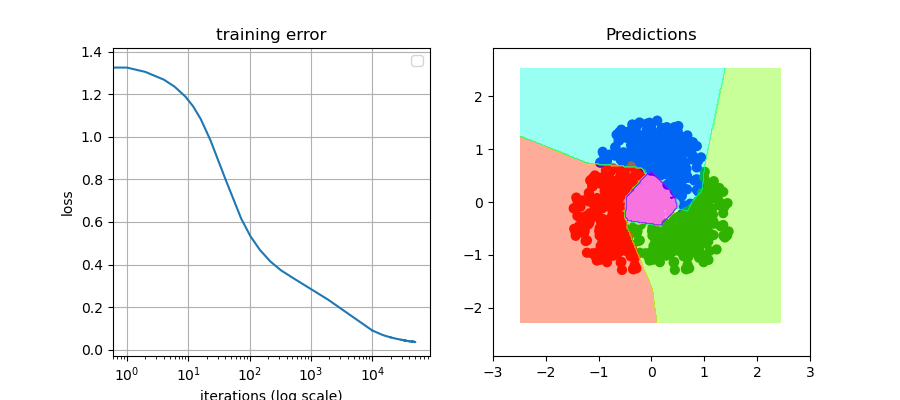

No handles with labels found to put in legend.


In [29]:
run_training(network=network_std_fss, epoch=MAX_TEST_TIMES, x=X_cat_nl, t=T_cat_nl, c=Y_cat_nl)

---